In [323]:
import os
import pandas as pd
import seaborn as sns
import tensorboard as tb
from pathlib import Path
from tbparse import SummaryReader
from matplotlib import pyplot as plt
from IPython.display import display

## 0.0 Plotting Settings

In [335]:
pd.set_option('display.max_rows', 200)
plotting_context = "paper"
default_palette = "colorblind"
font_scale = 1.5
sns.set(font_scale=font_scale, context=plotting_context)
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

## 0.1 Glue Code To Load Logs

In [372]:
LOG_DIR = "es-04-logs/.tb_logs"
log_path = Path(os.getcwd()) / Path(LOG_DIR)

def to_group_name(s):
    name = s.split("-")
    return name[0] + "-" + name[1]

def to_global_rank(s):
    if "CAI" in s:
        return s.split("-")[3][1:]
    else:
        return s.split("-")[2][1:]

def get_run_logs(log_path):
    reader = SummaryReader(log_path, extra_columns={"dir_name"}, pivot=True)
    
    config_df = reader.text
    config_df = config_df.drop("step", axis=1)
    config_df = config_df.rename(columns={"dir_name": "run_name"})
    config_df["group_name"] = config_df["run_name"].apply(lambda x: to_group_name(x))
    config_df["global_rank"] = config_df["run_name"].apply(lambda x: to_global_rank(x))
    
    display(config_df)
    
    runs_df = reader.tensors
    runs_df = runs_df.rename(columns={"dir_name": "run_name"})
    runs_df["group_name"] = runs_df["run_name"].apply(lambda x: to_group_name(x))
    runs_df["global_rank"] = runs_df["run_name"].apply(lambda x: to_global_rank(x))
    
    minibatch_label = "minibatch_size"
    runs_df[minibatch_label] = "0"
    for gname in runs_df["group_name"].unique():
        
        value = config_df.query(f"group_name=='{gname}'")["00_cfg/batch_size"].iloc[0]
        if isinstance(value,list):
            minibatch_value = value[0]
        else:
            minibatch_value = int(value)
        runs_df.loc[
            runs_df.group_name == gname,
            minibatch_label] = str(minibatch_value)
    return config_df, runs_df

## 0.2 Helper Visualization Functions

In [373]:
def set_fontsizes(small=8, medium=10, bigger=12):
    SMALL_SIZE = small
    MEDIUM_SIZE = medium
    BIGGER_SIZE = bigger

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    plt.rcParams['legend.title_fontsize'] = MEDIUM_SIZE
    
def set_palette(value="default"):
    default_palette = "tab10"
    if value == "rocket":
        rocket_cmap = sns.color_palette("rocket", 20)
        sns.set(palette=rocket_cmap)
    elif value == "default":
        sns.set(palette=default_palette)
set_palette("default")

## 0.3 Run Configuration For All Runs

In [374]:
config_df, runs_df = get_run_logs(log_path=log_path)

,00_cfg/backend,00_cfg/batch_size,00_cfg/config,00_cfg/cpu_core_count,00_cfg/cpu_offloading,00_cfg/cuda_version,00_cfg/distplan,00_cfg/distributed_debug,00_cfg/driver_version,00_cfg/enable_profiler,...,00_cfg/tokenizer,00_cfg/torch_version,00_cfg/total_memory_sys_MB,00_cfg/train_step,00_cfg/use_fp16,00_cfg/use_mixed_precision,00_cfg/world_size,run_name,group_name,global_rank
0,nccl,"[16, 16]",None,NaN,NaN,NaN,CAI_Gemini,NaN,NaN,NaN,...,NaN,NaN,NaN,50,NaN,NaN,None,CAI_Gemini-16-50-r0,CAI_Gemini-16,0
1,nccl,"[16, 16]",None,NaN,NaN,NaN,CAI_Gemini,NaN,NaN,NaN,...,NaN,NaN,NaN,50,NaN,NaN,None,CAI_Gemini-16-50-r1,CAI_Gemini-16,1
2,nccl,"[32, 32]",None,NaN,NaN,NaN,CAI_Gemini,NaN,NaN,NaN,...,NaN,NaN,NaN,50,NaN,NaN,None,CAI_Gemini-32-50-r0,CAI_Gemini-32,0
3,nccl,"[32, 32]",None,NaN,NaN,NaN,CAI_Gemini,NaN,NaN,NaN,...,NaN,NaN,NaN,50,NaN,NaN,None,CAI_Gemini-32-50-r1,CAI_Gemini-32,1
4,nccl,"[48, 48]",None,NaN,NaN,NaN,CAI_Gemini,NaN,NaN,NaN,...,NaN,NaN,NaN,50,NaN,NaN,None,CAI_Gemini-48-50-r0,CAI_Gemini-48,0
5,nccl,"[48, 48]",None,NaN,NaN,NaN,CAI_Gemini,NaN,NaN,NaN,...,NaN,NaN,NaN,50,NaN,NaN,None,CAI_Gemini-48-50-r1,CAI_Gemini-48,1
6,nccl,"[64, 64]",None,NaN,NaN,NaN,CAI_Gemini,NaN,NaN,NaN,...,NaN,NaN,NaN,50,NaN,NaN,None,CAI_Gemini-64-50-r0,CAI_Gemini-64,0
7,nccl,"[64, 64]",None,NaN,NaN,NaN,CAI_Gemini,NaN,NaN,NaN,...,NaN,NaN,NaN,50,NaN,NaN,None,CAI_Gemini-64-50-r1,CAI_Gemini-64,1
8,nccl,"[8, 8]",None,NaN,NaN,NaN,CAI_Gemini,NaN,NaN,NaN,...,NaN,NaN,NaN,50,NaN,NaN,None,CAI_Gemini-8-50-r0,CAI_Gemini-8,0
9,nccl,"[8, 8]",None,NaN,NaN,NaN,CAI_Gemini,NaN,NaN,NaN,...,NaN,NaN,NaN,50,NaN,NaN,None,CAI_Gemini-8-50-r1,CAI_Gemini-8,1


In [375]:
runs = ["CAI_Gemini-8"]

config_df.query(f"group_name in {runs}")[["00_cfg/batch_size", "00_cfg/model_name"]]

,00_cfg/batch_size,00_cfg/model_name
8,"[8, 8]",NaN
9,"[8, 8]",NaN


In [368]:
config_df.columns

Index(['00_cfg/backend', '00_cfg/batch_size', '00_cfg/config',
       '00_cfg/cpu_core_count', '00_cfg/cpu_offloading', '00_cfg/cuda_version',
       '00_cfg/distplan', '00_cfg/distributed_debug', '00_cfg/driver_version',
       '00_cfg/enable_profiler', '00_cfg/fsdp_activation_checkpointing',
       '00_cfg/gpu_0_id', '00_cfg/gpu_0_name', '00_cfg/gpu_0_pci_cur_link',
       '00_cfg/gpu_0_pci_cur_link_width', '00_cfg/gpu_0_pci_max_link',
       '00_cfg/gpu_0_pci_max_link_width', '00_cfg/gpu_0_vbios_version',
       '00_cfg/gpu_1_id', '00_cfg/gpu_1_name', '00_cfg/gpu_1_pci_cur_link',
       '00_cfg/gpu_1_pci_cur_link_width', '00_cfg/gpu_1_pci_max_link',
       '00_cfg/gpu_1_pci_max_link_width', '00_cfg/gpu_1_vbios_version',
       '00_cfg/gpu_count', '00_cfg/gpu_num', '00_cfg/host', '00_cfg/host_port',
       '00_cfg/local_rank', '00_cfg/max_step_count', '00_cfg/max_steps',
       '00_cfg/memory_snapshot_step', '00_cfg/memory_snapshotting',
       '00_cfg/model_checkpoint', '00_cfg/mode

In [369]:
config = "00_cfg/sharding_strategy"
run_name = "FSDP-12-r0"
print(f"{run_name}[{config}]:",config_df.query(f"run_name=='{run_name}'")[config].values)

FSDP-12-r0[00_cfg/sharding_strategy]: ['FULL_SHARD']


In [376]:
runs_df.query(f"group_name=='FSDP-20'").head(10)

,step,01_general/epoch,01_general/loss,01_general/sps,01_general/step,01_general/tokens_per_s,02_timing/actual_step_time_s,02_timing/backward_time_s,02_timing/calculated_step_time_s,02_timing/dataload_cuda_mode_time_s,...,process/memory/lib_memory_proc_MB,process/memory/resident_set_size_proc_MB,process/memory/shared_memory_proc_MB,process/memory/text_resident_set_proc_MB,process/memory/virtual_memory_size_proc_MB,process/voluntary_proc_ctx_switches,run_name,group_name,global_rank,minibatch_size
1974,0,1.0,11.140625,0.926290,1.0,948.521362,8.636600,2.624608,8.356209,0.000009,...,1839.259644,1372.041260,337.604614,2.17088,40467.804688,36202.0,FSDP-20-r0,FSDP-20,0,8
1975,1,1.0,11.148438,3.054065,2.0,3127.362793,2.619459,1.309015,2.529509,0.000007,...,1913.663452,1428.086792,341.303284,2.17088,40542.101562,36846.0,FSDP-20-r0,FSDP-20,0,8
1976,2,1.0,11.156250,3.867745,3.0,3960.571289,2.068388,1.310732,1.973966,0.000006,...,1916.817383,1431.404541,341.303284,2.17088,45981.066406,37255.0,FSDP-20-r0,FSDP-20,0,8
1977,3,1.0,11.148438,3.835460,4.0,3927.510742,2.085799,1.313027,1.974877,0.000007,...,1917.222900,1431.732178,341.303284,2.17088,45981.460938,37650.0,FSDP-20-r0,FSDP-20,0,8
1978,4,1.0,11.304688,4.010995,5.0,4107.259277,1.994517,1.313860,1.879332,0.000006,...,1917.784058,1432.293335,341.303284,2.17088,45981.609375,38065.0,FSDP-20-r0,FSDP-20,0,8
1979,5,1.0,11.210938,4.011232,6.0,4107.501465,1.994400,1.314676,1.881167,0.000006,...,1917.792236,1432.317993,341.303284,2.17088,45981.609375,38478.0,FSDP-20-r0,FSDP-20,0,8
1980,6,1.0,11.203125,4.006704,7.0,4102.864746,1.996654,1.314343,1.881771,0.000006,...,1917.820923,1432.363037,341.303284,2.17088,45981.609375,38886.0,FSDP-20-r0,FSDP-20,0,8
1981,7,1.0,11.164062,4.102769,8.0,4201.235352,1.949903,1.315323,1.882737,0.000007,...,1917.820923,1432.379395,341.303284,2.17088,45981.609375,39292.0,FSDP-20-r0,FSDP-20,0,8
1982,8,1.0,11.195312,4.002616,9.0,4098.678711,1.998693,1.316587,1.883896,0.000006,...,1917.820923,1432.391724,341.303284,2.17088,45981.609375,39708.0,FSDP-20-r0,FSDP-20,0,8
1983,9,1.0,11.203125,4.017152,10.0,4113.563477,1.991461,1.315414,1.882175,0.000006,...,1917.820923,1432.399902,341.303284,2.17088,45981.609375,40119.0,FSDP-20-r0,FSDP-20,0,8


## Preprocess Log DataFrame

In [332]:
steps_in_epoch = runs_df["01_general/step"].max()
runs_df.loc[:, "global_step"] = runs_df["01_general/step"] +  ((runs_df["01_general/epoch"] - 1) * steps_in_epoch)

In [333]:
for col in runs_df.columns:
    print(col)

step
01_general/epoch
01_general/loss
01_general/sps
01_general/step
01_general/tokens_per_s
02_timing/actual_step_time_s
02_timing/backward_time_s
02_timing/calculated_step_time_s
02_timing/dataload_cuda_mode_time_s
02_timing/dataload_time_s
02_timing/forward_time_s
02_timing/opt_step_time_s
02_timing/running_epoch_time_s
02_timing/running_training_time_s
02_timing/zero_grad_time_s
03_gpu_mem/active.all.allocated
03_gpu_mem/active.all.current
03_gpu_mem/active.all.freed
03_gpu_mem/active.all.peak
03_gpu_mem/active.large_pool.allocated
03_gpu_mem/active.large_pool.current
03_gpu_mem/active.large_pool.freed
03_gpu_mem/active.large_pool.peak
03_gpu_mem/active.small_pool.allocated
03_gpu_mem/active.small_pool.current
03_gpu_mem/active.small_pool.freed
03_gpu_mem/active.small_pool.peak
03_gpu_mem/active_bytes.all.allocated
03_gpu_mem/active_bytes.all.current
03_gpu_mem/active_bytes.all.freed
03_gpu_mem/active_bytes.all.peak
03_gpu_mem/active_bytes.large_pool.allocated
03_gpu_mem/active_byt

## Experiment Count

In [338]:
print(f"Experiment Count: {len(config_df['group_name'].unique())}")
print(config_df['group_name'].unique())

Experiment Count: 33
['CAI_Gemini-16' 'CAI_Gemini-32' 'CAI_Gemini-48' 'CAI_Gemini-64'
 'CAI_Gemini-8' 'CAI_Gemini-88' 'CAI_Gemini-98' 'FSDP-0' 'FSDP-1'
 'FSDP-10' 'FSDP-11' 'FSDP-12' 'FSDP-13' 'FSDP-14' 'FSDP-15' 'FSDP-16'
 'FSDP-17' 'FSDP-18' 'FSDP-19' 'FSDP-2' 'FSDP-20' 'FSDP-21' 'FSDP-22'
 'FSDP-23' 'FSDP-24' 'FSDP-25' 'FSDP-3' 'FSDP-4' 'FSDP-5' 'FSDP-6'
 'FSDP-7' 'FSDP-8' 'FSDP-9']


## 1.0 Calculate the Overhead For Logging For All Runs

/Users/alexanderisenko/miniconda3/envs/fsdp-analysis/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/alexanderisenko/miniconda3/envs/fsdp-analysis/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/alexanderisenko/miniconda3/envs/fsdp-analysis/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/alexanderisenko/miniconda3/envs/fsdp-analysis/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


[Text(0, 0, 'CAI_Gemini-16'),
 Text(1, 0, 'CAI_Gemini-32'),
 Text(2, 0, 'CAI_Gemini-48'),
 Text(3, 0, 'CAI_Gemini-64'),
 Text(4, 0, 'CAI_Gemini-8'),
 Text(5, 0, 'CAI_Gemini-88'),
 Text(6, 0, 'CAI_Gemini-98'),
 Text(7, 0, 'FSDP-0'),
 Text(8, 0, 'FSDP-1'),
 Text(9, 0, 'FSDP-10'),
 Text(10, 0, 'FSDP-11'),
 Text(11, 0, 'FSDP-12'),
 Text(12, 0, 'FSDP-13'),
 Text(13, 0, 'FSDP-14'),
 Text(14, 0, 'FSDP-15'),
 Text(15, 0, 'FSDP-16'),
 Text(16, 0, 'FSDP-17'),
 Text(17, 0, 'FSDP-18'),
 Text(18, 0, 'FSDP-19'),
 Text(19, 0, 'FSDP-2'),
 Text(20, 0, 'FSDP-20'),
 Text(21, 0, 'FSDP-21'),
 Text(22, 0, 'FSDP-22'),
 Text(23, 0, 'FSDP-23'),
 Text(24, 0, 'FSDP-24'),
 Text(25, 0, 'FSDP-25'),
 Text(26, 0, 'FSDP-3'),
 Text(27, 0, 'FSDP-4'),
 Text(28, 0, 'FSDP-5'),
 Text(29, 0, 'FSDP-6'),
 Text(30, 0, 'FSDP-7'),
 Text(31, 0, 'FSDP-8'),
 Text(32, 0, 'FSDP-9')]

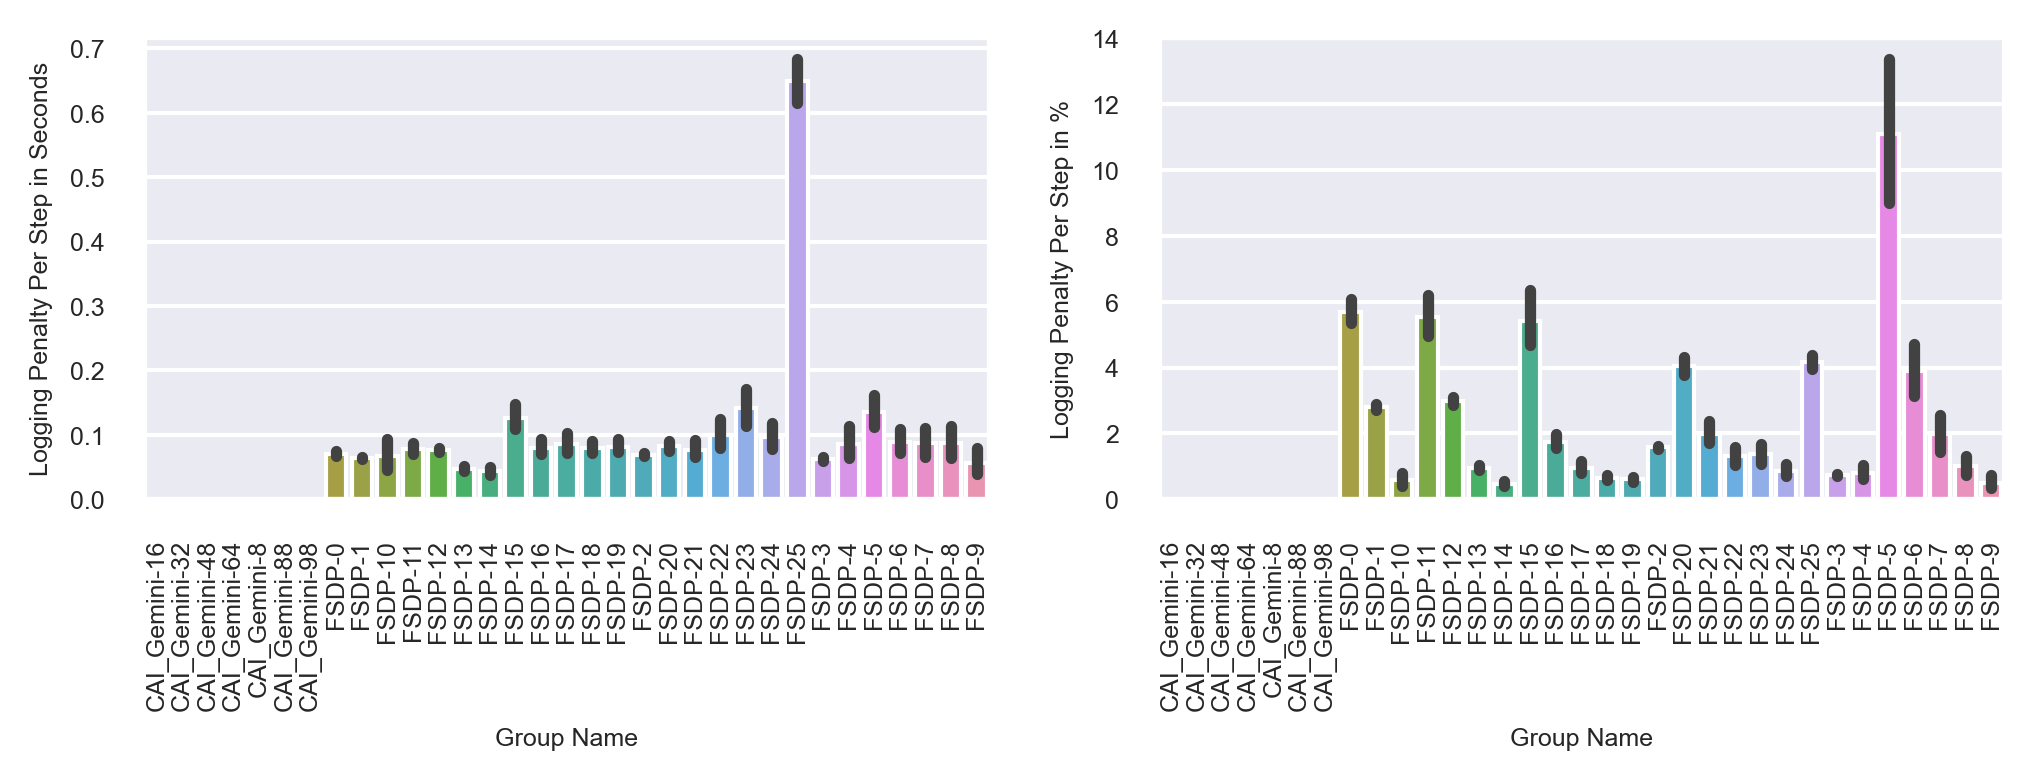

In [191]:
runs_df.loc[:, "logging_penalty_per_step_s"] = runs_df["02_timing/actual_step_time_s"] - runs_df["02_timing/calculated_step_time_s"]
runs_df.loc[:, "logging_penalty_per_step_percent"] = runs_df["logging_penalty_per_step_s"] / runs_df["02_timing/calculated_step_time_s"] * 100

valid_runs = [
    #"FSDP-63",
    #"FSDP-65",
    "FSDP-8",
]

temp_df = runs_df.copy()# .query(f"group_name in {valid_runs}")

set_palette()
set_fontsizes(6,6,8)

fig, ax = plt.subplots(1, 2, figsize=(8,2))
fig = sns.barplot(
    data=temp_df,
    x="group_name",
    y="logging_penalty_per_step_s",
    ax=ax[0]
)
#ax[0].set_xticks(rotation=90)
ax[0].set_ylabel("Logging Penalty Per Step in Seconds")
ax[0].set_xlabel("Group Name")
ax[0].set_xticklabels(temp_df["group_name"].unique(), rotation=90)
fig = sns.barplot(
    data=temp_df,
    x="group_name",
    y="logging_penalty_per_step_percent",
    ax=ax[1]
)
ax[1].set_ylabel("Logging Penalty Per Step in %")
ax[1].set_xlabel("Group Name")
ax[1].set_xticklabels(temp_df["group_name"].unique(), rotation=90)

## 1.1 All Timings Visualized

In [147]:
valid_runs = [
    "FSDP-0",
    "FSDP-1",
    "FSDP-2",
    "FSDP-3",
    "FSDP-4",
    "FSDP-5",
    "FSDP-6",
    "FSDP-7",
    "FSDP-8",
    "FSDP-9",
    #"FSDP-8",
    #"CAI_Gemini-92",
]

temp_df = runs_df.copy().query(f"group_name in {valid_runs}")
x = "group_name"
#x = "global_rank"

plottype = "bar"
#plottype = "violin"

Text(0.5, 0.98, 'All Timings')

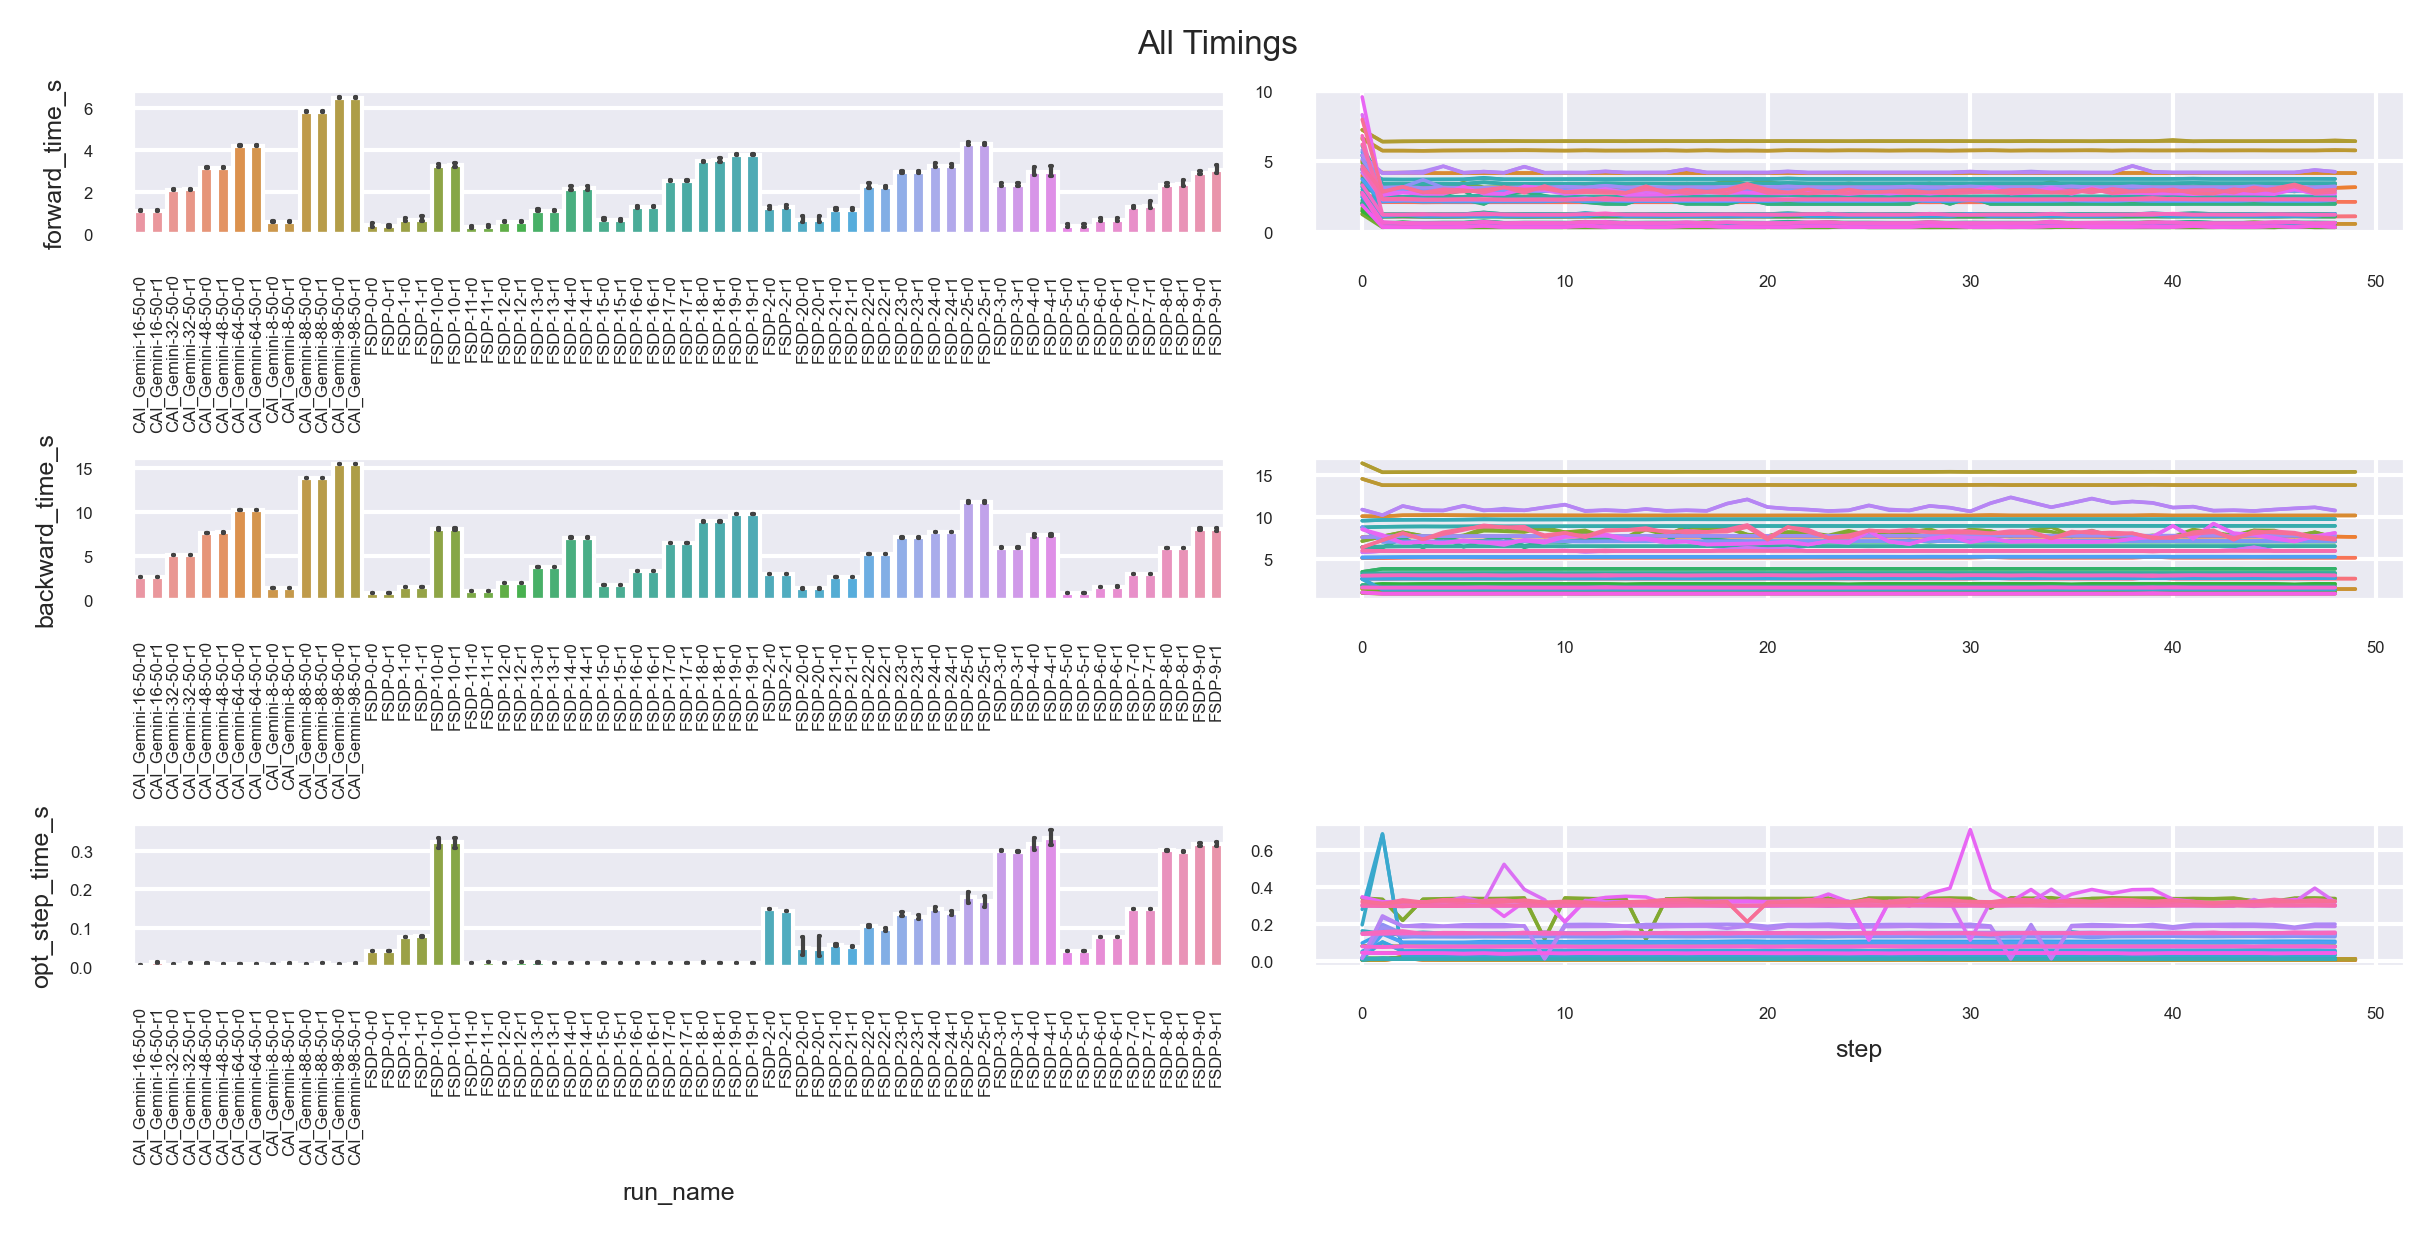

In [192]:
set_fontsizes(4,6,8)
#fig, axs = plt.subplots(3, 6, figsize=(8, 4), layout='constrained')
fig, axs = plt.subplots(3, 2, figsize=(8, 4), layout='constrained')
timings = [
    #"02_timing/dataload_time_s","02_timing/dataload_time_s",
    #"02_timing/dataload_cuda_mode_time_s","02_timing/dataload_cuda_mode_time_s",
    #"02_timing/zero_grad_time_s","02_timing/zero_grad_time_s",
    "02_timing/forward_time_s","02_timing/forward_time_s",
    "02_timing/backward_time_s","02_timing/backward_time_s",
    "02_timing/opt_step_time_s","02_timing/opt_step_time_s",
    #"02_timing/calculated_step_time_s","02_timing/calculated_step_time_s",
    #"02_timing/actual_step_time_s","02_timing/actual_step_time_s",
    #"02_timing/running_epoch_time_s","02_timing/running_epoch_time_s"
]
timing_ax_map = list(zip(timings, axs.flat))

for (name1, ax1), (name2, ax2) in list(zip(timing_ax_map, timing_ax_map[1:]))[::2]:
    if plottype == "violin":
        ax1 = sns.violinplot(
            data=temp_df,
            x=x,
            y=name1,
            linewidth=0.5,
            whis=0.5,
            fliersize=0.5,
            ax=ax1)
    else:
        ax1 = sns.barplot(
            data=temp_df,
            x=x,
            y=name1,
            errorbar=("ci", 95),
            errwidth=1,
            capsize=0.08,
            ax=ax1)
    ax1.set_xticklabels(temp_df[x].unique(), rotation=90)#, ha='right')
    ax1.set_ylabel(name1.replace("02_timing/", ""))
    ax2 = sns.lineplot(
        data=temp_df,
        x="step",
        y=name2,
        ax=ax2,
        hue=x,
        linewidth=0.85,
        errorbar=('ci', 95))
    ax2.get_legend().remove()
    ax2.set_ylabel("")
    if not ("step" in name1 or "epoch" in name1):
        ax1.set_xlabel("")
        ax2.set_xlabel("")

fig.suptitle("All Timings")

## 1.2 Selective Metrics View

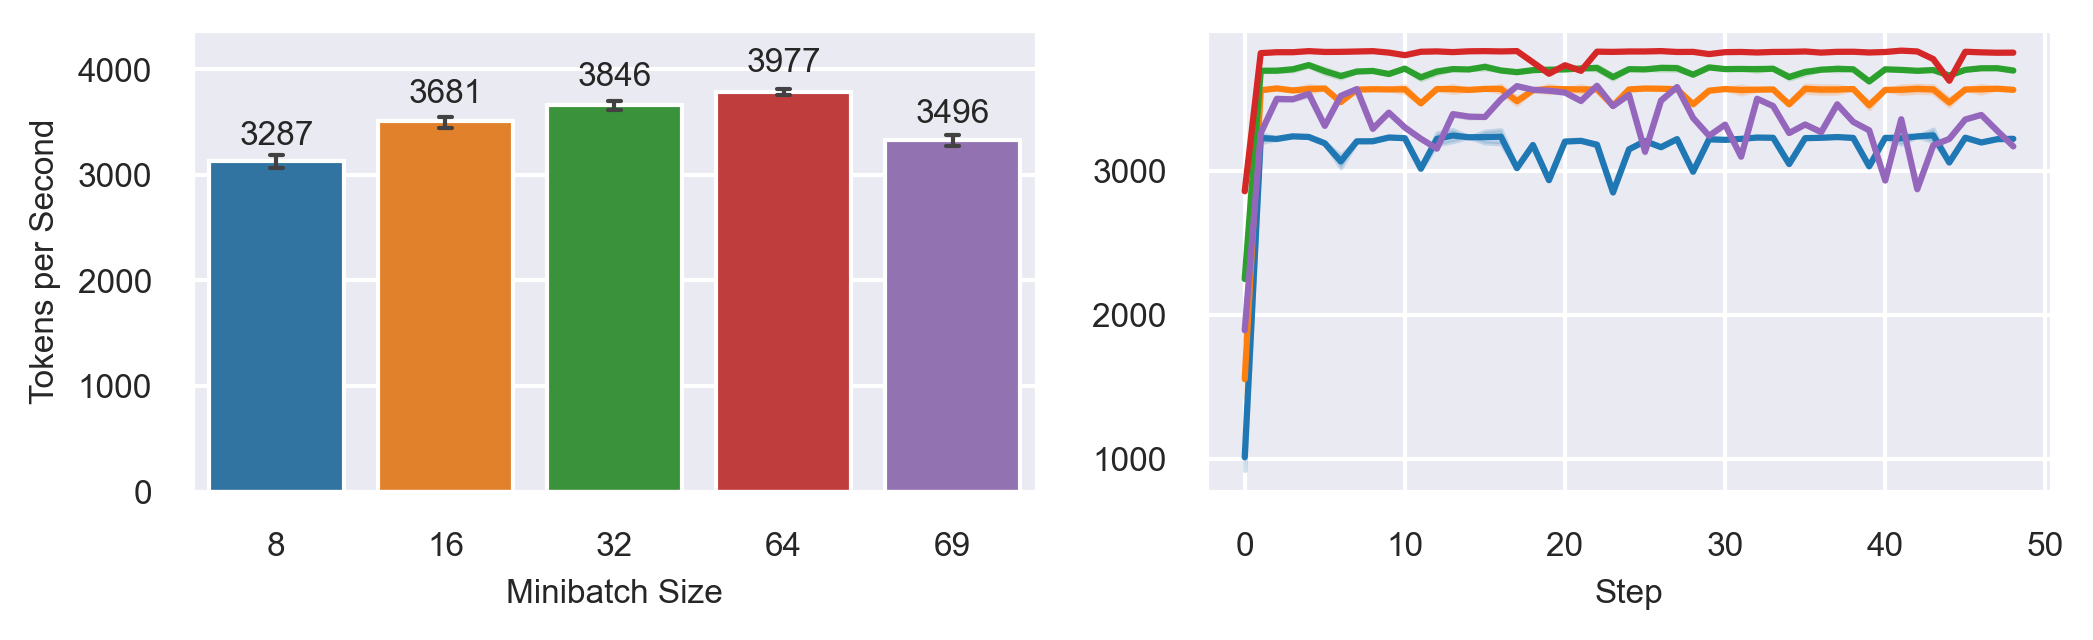

In [386]:
def show_barplot_values(ax, decimals=2):
    
    max_y = 0
    for (p_ix, p) in enumerate(ax.patches):
        #if p_ix >= (len(ax.patches) / 2):
        #p_ix = p_ix - (len(ax.patches) / 2)
        _x = p.get_x() + p.get_width() / 2
        _y = p.get_y() + (p.get_height() * 1.05)
        max_y = max(max_y, _y)
        if decimals == 2:
            value = '{:.2f}'.format(_y)
        elif decimals == 1:
            value = '{:.1f}'.format(_y)
        elif decimals == 0:
            value = '{:.0f}'.format(_y)
        ax.text(_x, _y, value, ha="center")
        
    visualized_max_y = max_y * 1.10
    ax.set_ylim([0, visualized_max_y])

def dual_plot(df, x, y, line_ylim=None, figsize=(8,2), title=None, rotation=90, decimals=2):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=figsize)
    ax1 = sns.barplot(
        data=df,
        x=x,
        y=y,
        ax=ax1,
        errorbar=("ci", 95),
        errwidth=1,
        capsize=0.08)
    ax1.set_xticklabels(df[x].unique(), rotation=rotation)#, ha='right')
    show_barplot_values(ax = ax1, decimals=decimals)
    ax2 = sns.lineplot(
        data=df,
        x="step",
        y=y,
        ax=ax2,
        hue=x)
    ax2.set_ylabel("")
    ax2.set_ylim(line_ylim)
    if title != None:
        fig.suptitle(title)
    return ax1, ax2

set_fontsizes(8,8,7)

valid_runs = [
    "FSDP-0",
    "FSDP-1",
    "FSDP-2",
    "FSDP-3",
    "FSDP-4",
#    "FSDP-25"
]

temp_df = runs_df.copy().query(f"group_name in {valid_runs}")

#x = "group_name"
x = "minibatch_size"
y = "01_general/tokens_per_s"
ax1, ax2 = dual_plot(df=temp_df, x=x, y=y, rotation=0, decimals=0)
ax1.set_ylabel("Tokens per Second")
ax1.set_xlabel("Minibatch Size")
ax2.set_xlabel("Step")
ax2.legend_.remove()

##  Step Timing Of All Runs

[Text(0, 0, 'FSDP-20'),
 Text(1, 0, 'FSDP-21'),
 Text(2, 0, 'FSDP-22'),
 Text(3, 0, 'FSDP-24'),
 Text(4, 0, 'FSDP-25')]

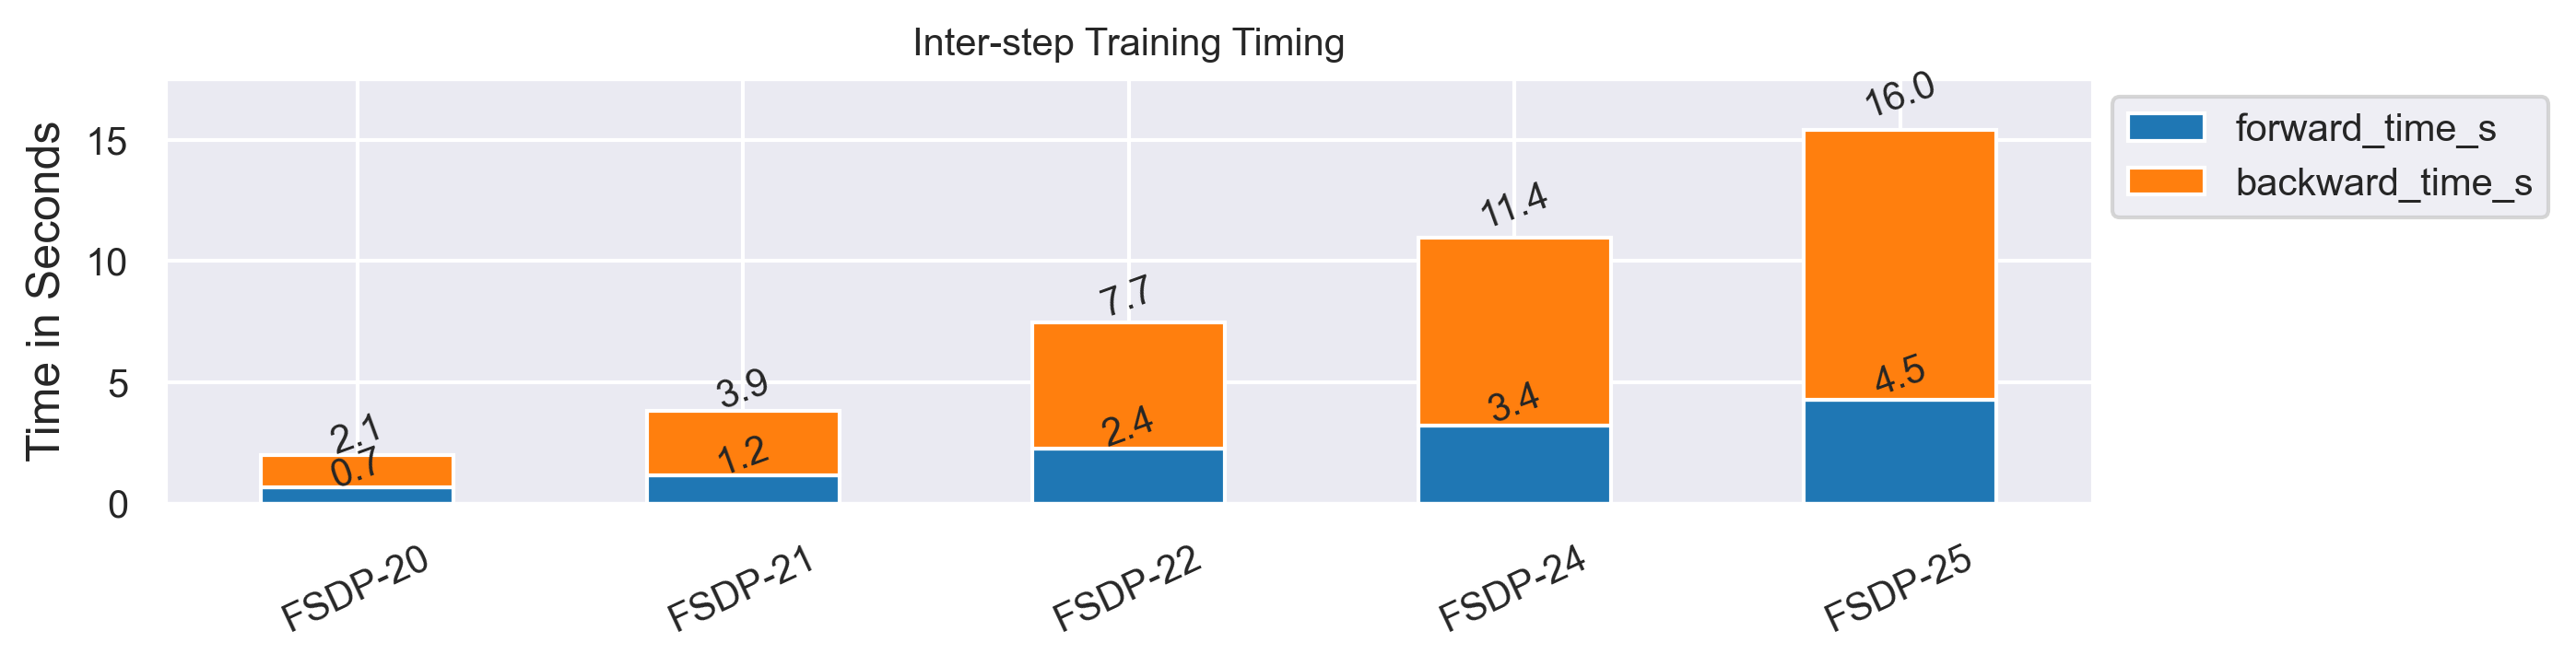

In [445]:
set_fontsizes(10,12,14)

def get_average_step_timings(df):
    mean_df = df.mean(numeric_only=True).to_frame().T
    mean_df["run_name"] = df["run_name"].unique()[0][:-3]
    mean_df = mean_df.rename(columns={
                            #"02_timing/dataload_time_s": "dataload_time_s",
                            #"02_timing/dataload_cuda_mode_time_s": "dataload_cuda_mode_time_s",
                            #"02_timing/zero_grad_time_s": "zero_grad_time_s",
                            "02_timing/forward_time_s": "forward_time_s",
                            "02_timing/backward_time_s": "backward_time_s",
                            #"02_timing/opt_step_time_s": "opt_step_time_s",
                            #"logging_penalty_per_step_s": "logging_penalty_s"
                            })
    
    exported_labels = [
        #"dataload_time_s",
        #"dataload_cuda_mode_time_s",
        #"zero_grad_time_s",
        "forward_time_s",
        "backward_time_s",
        #"opt_step_time_s",
        #"logging_penalty_s",
        "run_name"]
    return mean_df[exported_labels], exported_labels

timings = []

valid_runs = [
    "FSDP-20",
    "FSDP-21",
    "FSDP-22",
    #"FSDP-23",
    "FSDP-24",
    "FSDP-25",
    #"CAI_Gemini-8",
    #"CAI_Gemini-16",
    #"CAI_Gemini-32",
    #"CAI_Gemini-48",
    #"CAI_Gemini-64",
    #"CAI_Gemini-88",
    #"CAI_Gemini-98",
]

temp_df = runs_df.copy().query(f"group_name in {valid_runs}")

for run_name in temp_df["run_name"].unique():
    single_run = temp_df.query(f"run_name=='{run_name}'")
    if not ("r1" in run_name):
        avg_step_timing_df, exported_labels = get_average_step_timings(df=single_run)
        timings.append(avg_step_timing_df)

all_step_timings_df = pd.concat(objs=timings)
all_step_timings_df = all_step_timings_df.sort_values(by=["backward_time_s"])
ax = all_step_timings_df[exported_labels].set_index("run_name").plot(kind="bar", stacked=True, figsize=(9,2))
plt.ylabel("Time in Seconds")
plt.xlabel("")
plt.title("Inter-step Training Timing")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))
show_barplot_values(ax=ax, decimals=1)
ax.set_xticklabels(all_step_timings_df["run_name"].unique(), rotation=25)



## GPU Memory Statistics

In [157]:
def plot_complex_metrics(
    data,
    name,
    ax,
    convert_to_mill=True,
    full_metrics=False):
    
    if convert_to_mill:
        denominator = 1000**2
        if "bytes" in name:
            y_label = name.replace("_bytes", "in MB")
        else:
            y_label = name + " in 1M"
    else:
        denominator = 1
        if "bytes" in name:
            y_label = name.replace("_bytes", " in Byte")
        else:
            y_label = name + " count"
    
    if "oversize_allocations" in name or \
           "oversize_segments" in name:
        postfix = "."
    else:
        postfix = ".all."
    
    x  = data["step"].reset_index(drop=True)
    y1 = data[f"03_gpu_mem/{name}{postfix}allocated"].reset_index(drop=True) / denominator
    y2 = data[f"03_gpu_mem/{name}{postfix}current"].reset_index(drop=True) / denominator
    y3 = data[f"03_gpu_mem/{name}{postfix}freed"].reset_index(drop=True) / denominator
    y4 = data[f"03_gpu_mem/{name}{postfix}peak"].reset_index(drop=True) / denominator

    legend_handles = []
    if full_metrics:
        y1_h,  = ax.plot(x, y1, linestyle="dashed", label="allocated")
        y3_h, = ax.plot(x, y3, linestyle='dashdot', label="free")
        legend_handles.append(y1_h)
        legend_handles.append(y3_h)
    y2_h, = ax.plot(x, y2, linestyle='dotted', label="current", linewidth=1)
    y4_h, = ax.plot(x, y4, linestyle='solid', label="peak", linewidth=1)
    legend_handles.append(y2_h)
    legend_handles.append(y4_h)

    ax.set_xlabel("Global Step")
    ax.set_ylabel(y_label)
    ax.legend(handles=legend_handles)

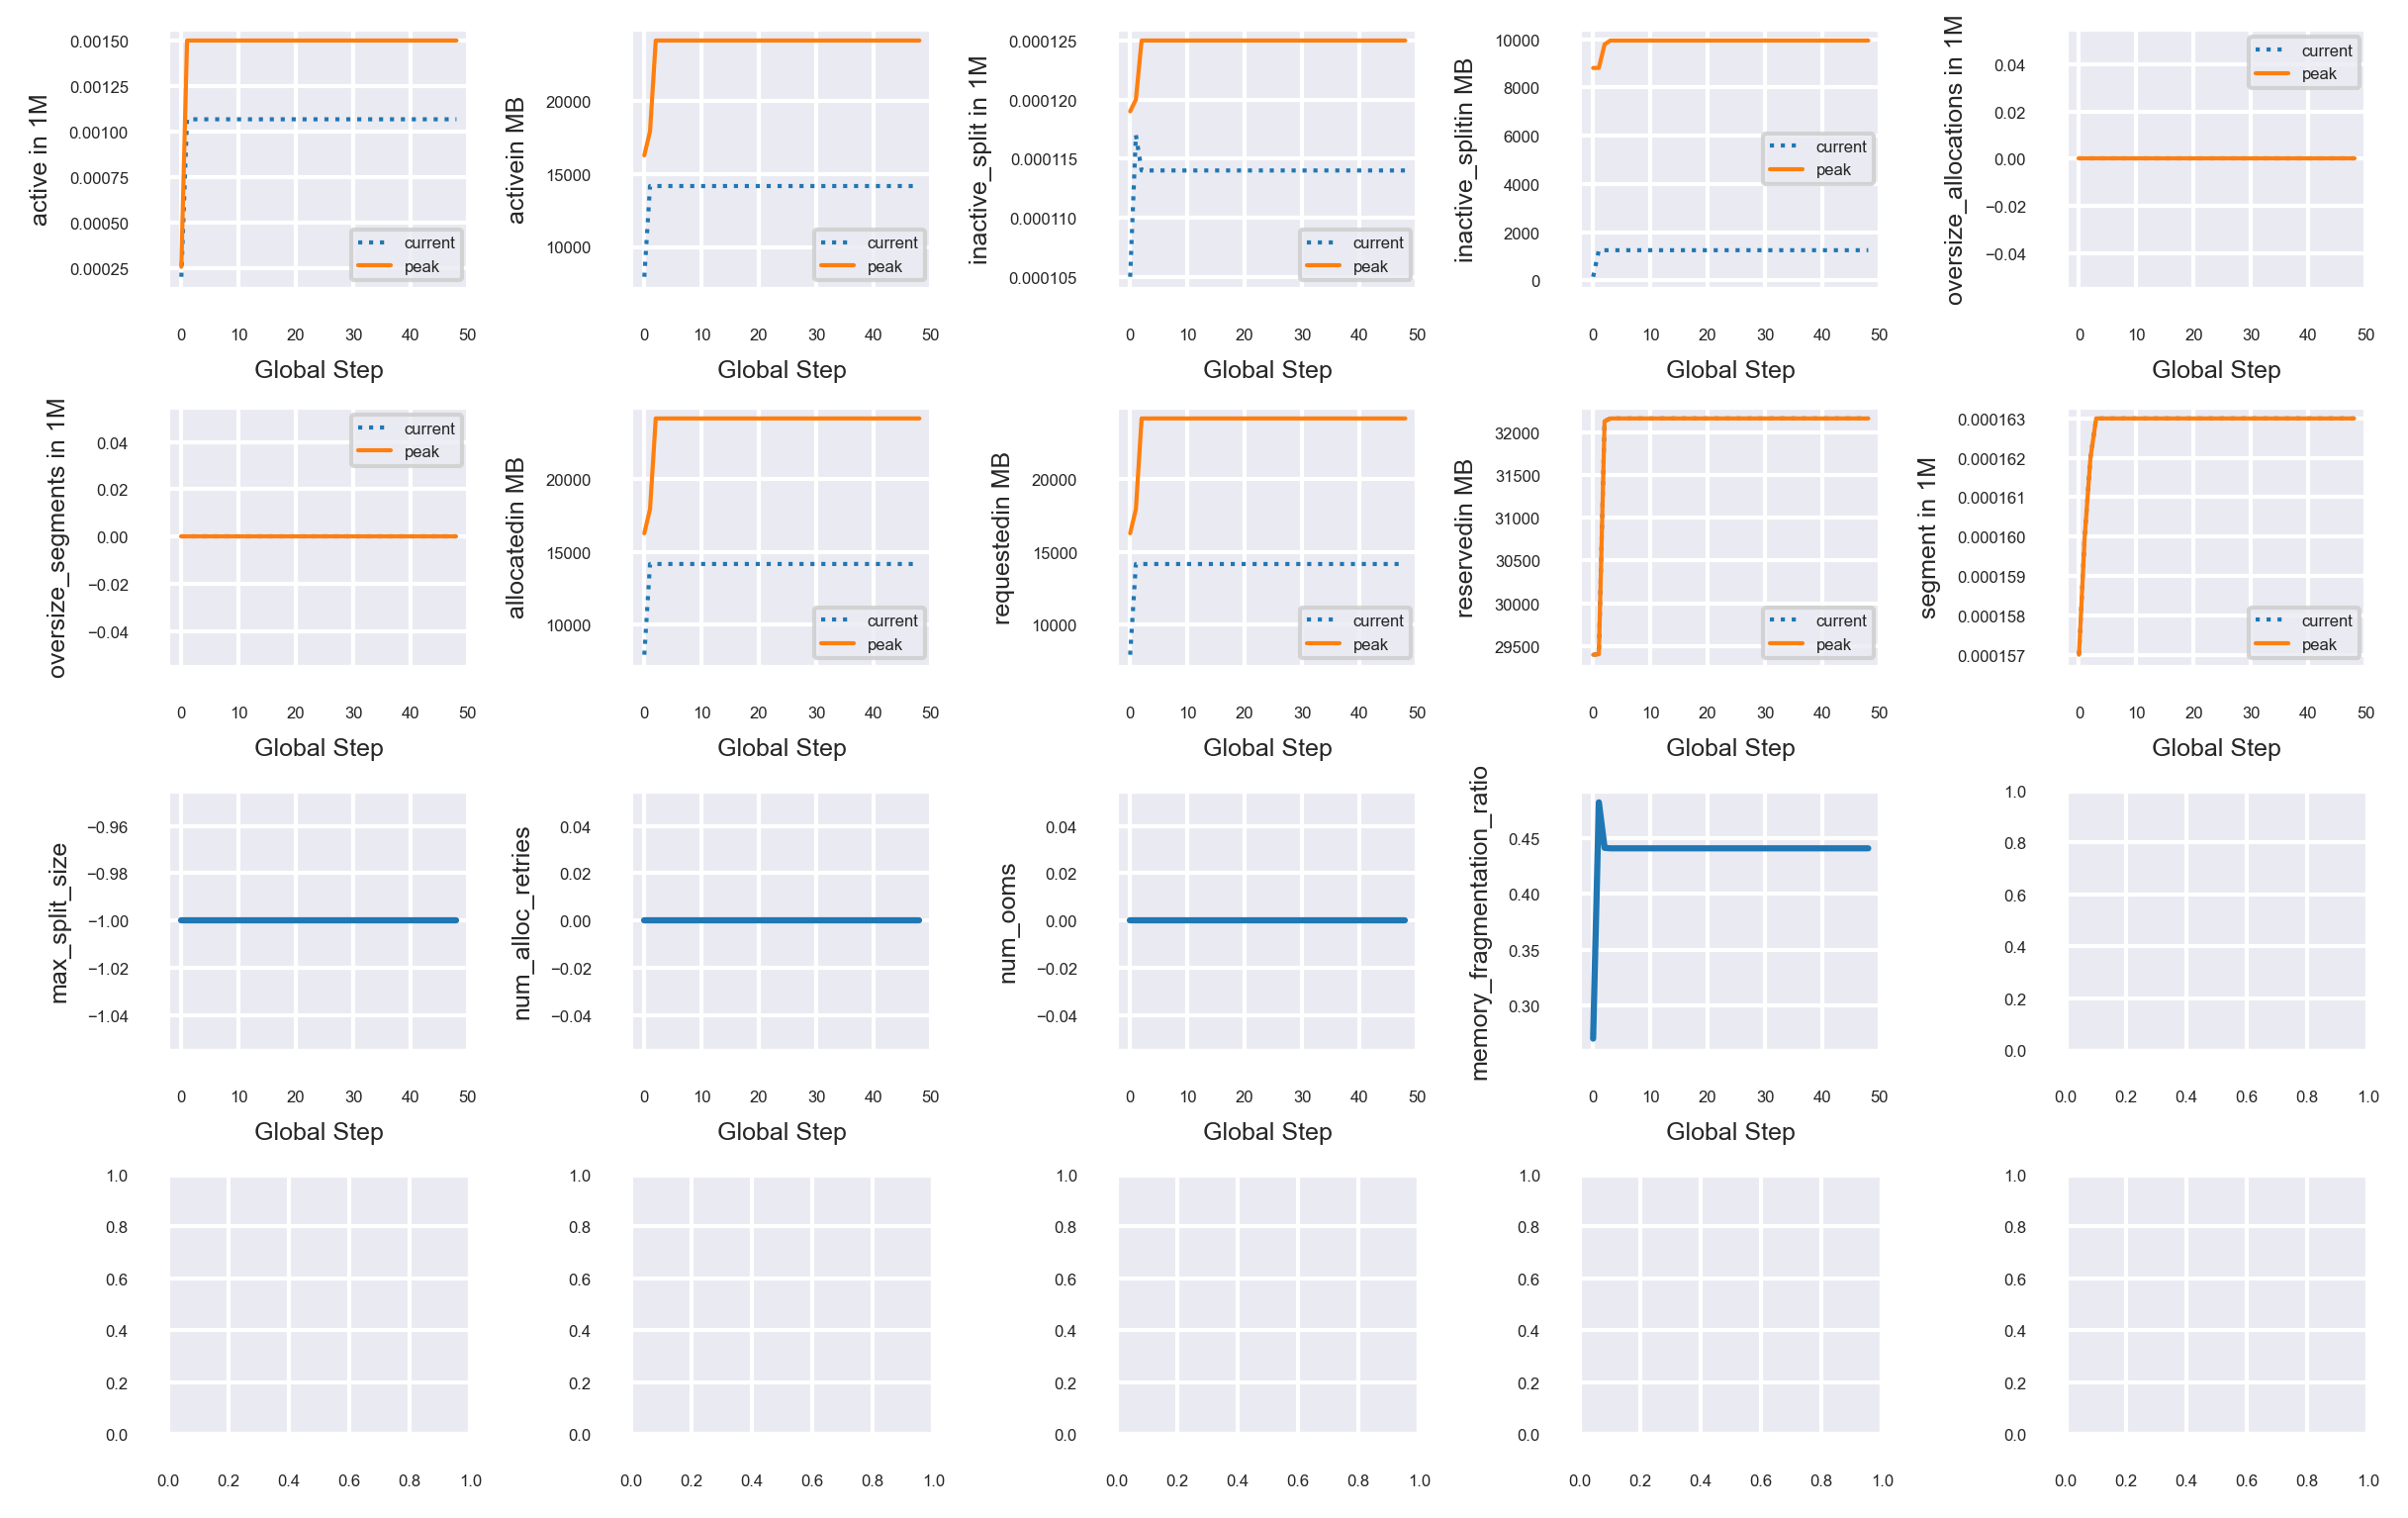

In [296]:
#temp_df = runs_df.query("run_name=='CAI_Gemini-92-2-20'").copy()
temp_df = runs_df.query("run_name=='FSDP-21-r0'").copy()

set_fontsizes(4,6,8)
fig, axs = plt.subplots(4, 5, figsize=(8, 5), layout='constrained')
gpu_metrics = [
    "active",
    "active_bytes",
    "inactive_split",
    "inactive_split_bytes",
    "oversize_allocations",
    "oversize_segments",
    "allocated_bytes",
    "requested_bytes",
    "reserved_bytes", 
    "segment",
    "03_gpu_mem/max_split_size",
    "03_gpu_mem/num_alloc_retries",
    "03_gpu_mem/num_ooms",
    #"04_agg_gpu/allocation_rounding_overhead_bytes",
    #"04_agg_gpu/avg_block_size_current_bytes",
    #"04_agg_gpu/avg_inactive_block_size_current_bytes",
    #"04_agg_gpu/avg_segment_size_current_bytes",
    #"04_agg_gpu/avg_large_segment_size_current_bytes",
    #"04_agg_gpu/avg_small_segment_size_current_bytes",
    "04_agg_gpu/memory_fragmentation_ratio"
    
]
gpu_metrics_ax_map = list(zip(gpu_metrics, axs.flat))

for name, ax in gpu_metrics_ax_map:
    if "/" in name:
        
        y_label = name.replace("03_gpu_mem/", "")
        y_label = y_label.replace("04_agg_gpu/", "")
        
        if "bytes" in name:
            temp_df.loc[:, f"{y_label}_mb"] = temp_df[name] / 1000**2

            ax = sns.lineplot(
                data=temp_df,
                x="step",
                y=f"{y_label}_mb",
                ax=ax,
            )
            y_label = y_label.replace("_bytes", "")
            ax.set_ylabel(f"{y_label} in MB")
        else:
            ax = sns.lineplot(
                    data=temp_df,
                    x="step",
                    y=name,
                    ax=ax,
                )

            ax.set_ylabel(y_label)

        ax.set_xlabel("Global Step")
    else:
        plot_complex_metrics(
            data=temp_df,
            name=name,
            ax=ax)

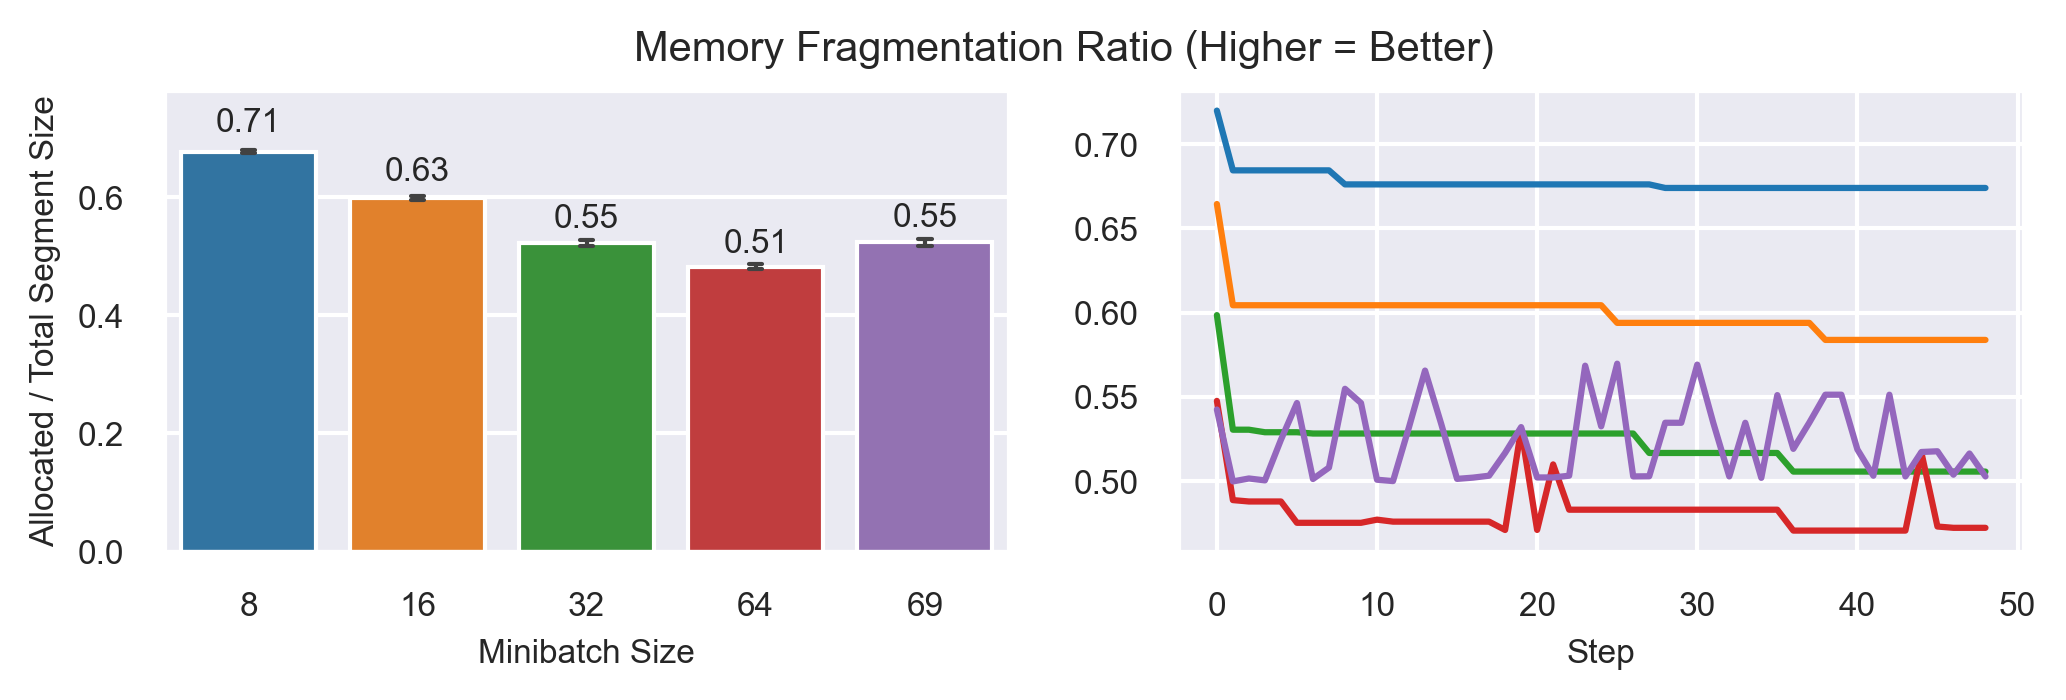

In [391]:
set_fontsizes(8,8,10)

valid_runs = [
    "FSDP-0",
    "FSDP-1",
    "FSDP-2",
    "FSDP-3",
    "FSDP-4",
#    "FSDP-24",
#    "FSDP-25",
]

temp_df = runs_df.copy().query(f"group_name in {valid_runs} and global_rank=='0'")
x = "minibatch_size"
y = "04_agg_gpu/memory_fragmentation_ratio"
ax1, ax2 = dual_plot(df=temp_df, x=x, y=y, title="Memory Fragmentation Ratio (Higher = Better)", rotation=0)
ax1.set_xlabel("Minibatch Size")
ax1.set_ylabel("Allocated / Total Segment Size")
ax2.set_xlabel("Step")
ax2.legend_.remove()

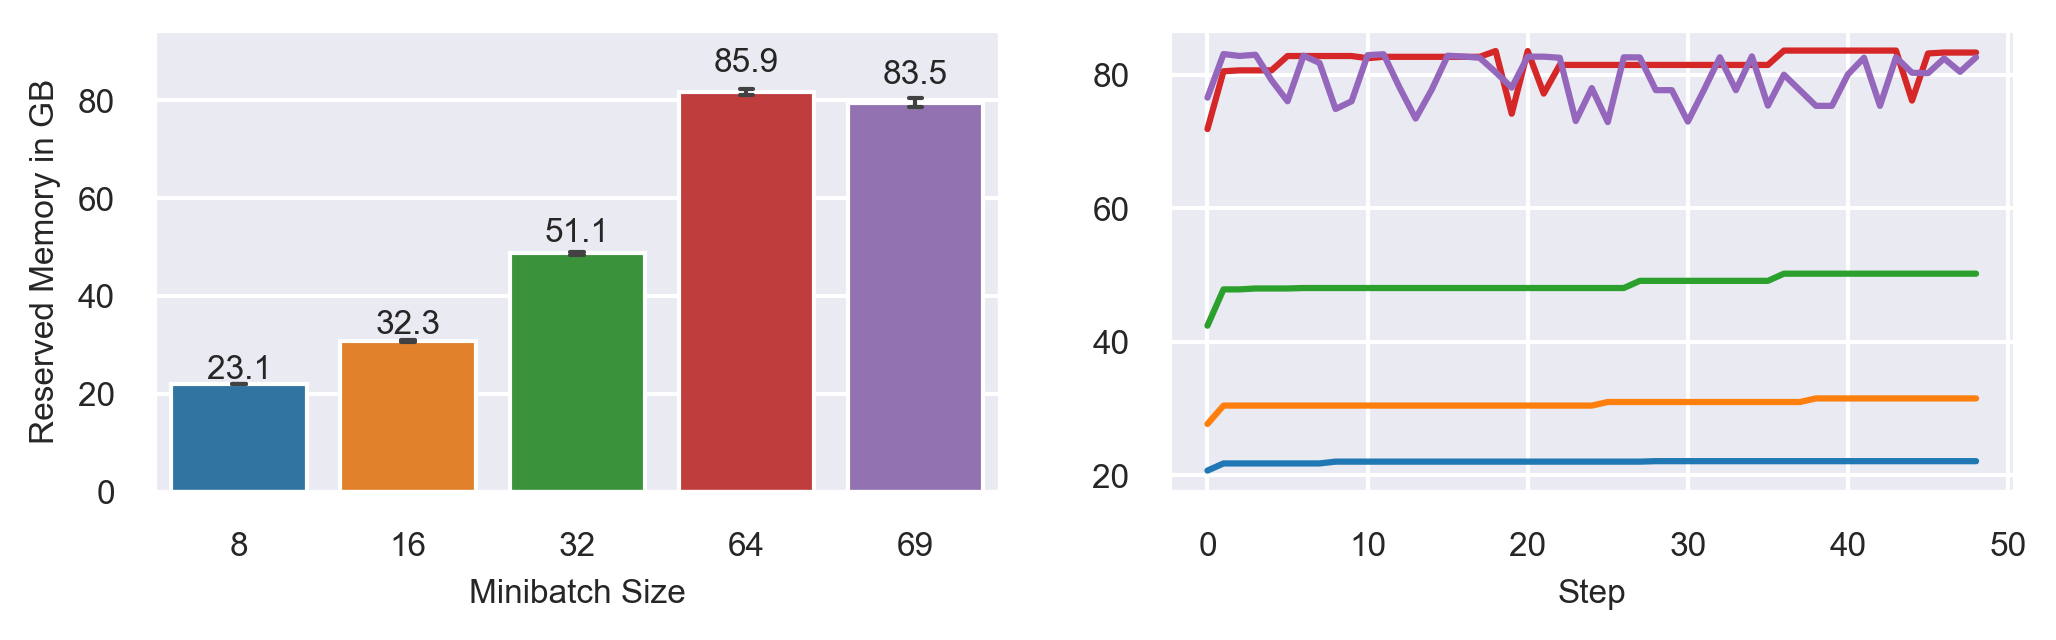

In [388]:
set_fontsizes(8,8,10)
valid_runs = [
    "FSDP-0",
    "FSDP-1",
    "FSDP-2",
    "FSDP-3",
    "FSDP-4",
]
temp_df = runs_df.copy().query(f"group_name in {valid_runs} and global_rank=='0'")

temp_df["reserved_gb.all_current"] = temp_df["03_gpu_mem/reserved_bytes.all.current"] / 1000**3
x = "minibatch_size"
y = "reserved_gb.all_current"
ax1, ax2 = dual_plot(df=temp_df, x=x, y=y, decimals=1, rotation=0)
ax1.set_ylabel("Reserved Memory in GB")
ax1.set_xlabel("Minibatch Size")
ax2.set_xlabel("Step")
ax2.legend_.remove()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

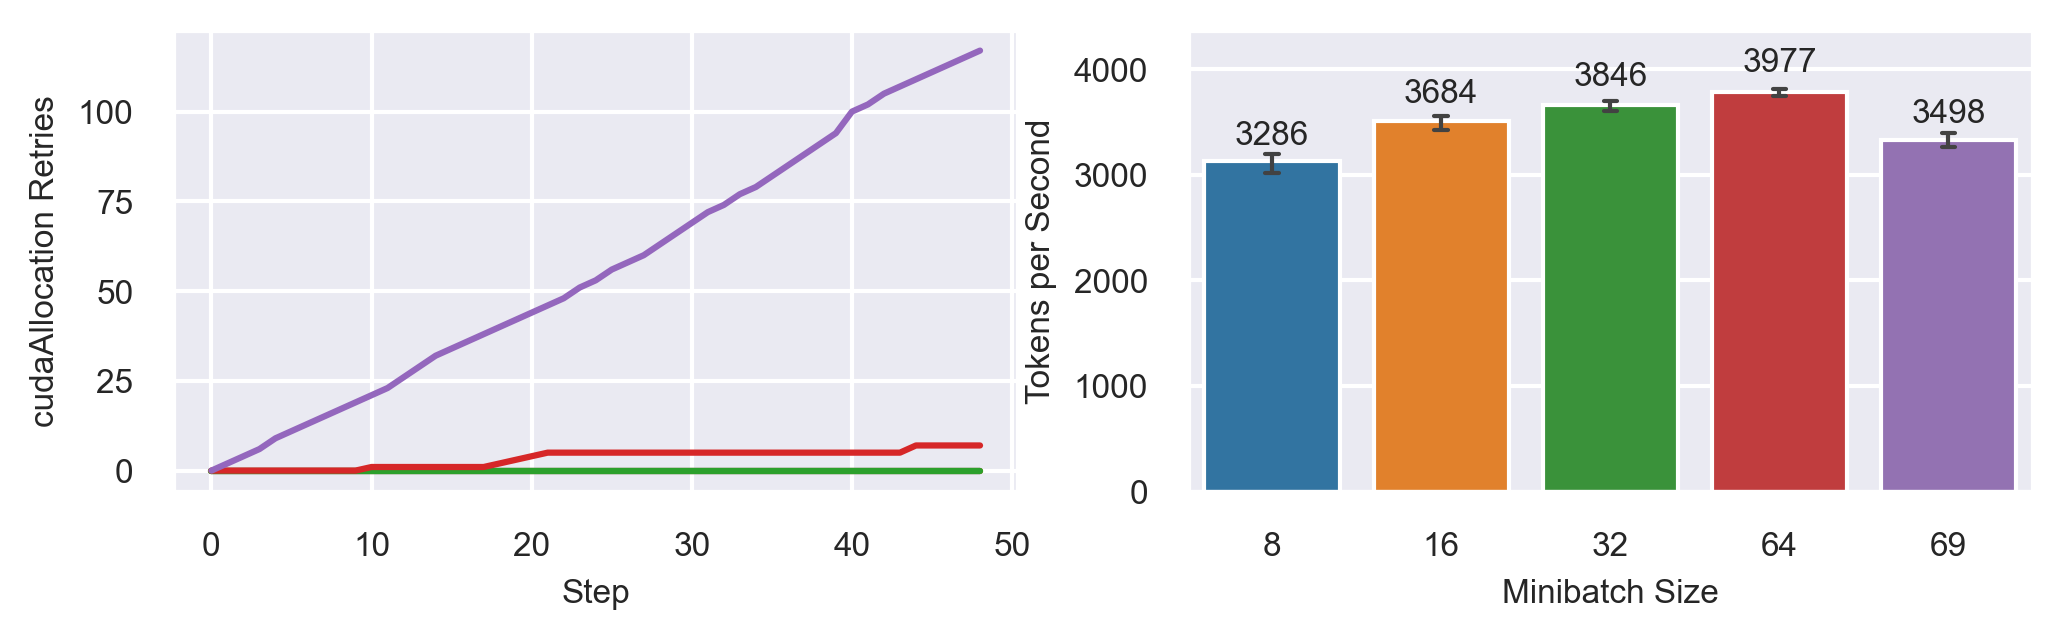

In [400]:
set_fontsizes(8,8,10)
valid_runs = [
    "FSDP-0",
    "FSDP-1",
    "FSDP-2",
    "FSDP-3",
    "FSDP-4",
    
]

temp_df = runs_df.copy().query(f"group_name in {valid_runs} and global_rank=='0'")
#temp_df["avg_segment_size_MB"] = temp_df["04_agg_gpu/avg_large_segment_size_current_bytes"] / 1000**2
x = "minibatch_size"
y1 = "01_general/tokens_per_s"
y2 = "03_gpu_mem/num_alloc_retries"

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,2))

sns.barplot(
    data=temp_df,
    x=x,
    y=y1,
    hue=x,
    ax=ax2,
    errorbar=("ci", 95),
    errwidth=1,
    capsize=0.08,
    dodge=False
)
ax2.set_xlabel("Minibatch Size")
ax2.set_ylabel("Tokens per Second")
ax2.legend_.remove()
show_barplot_values(ax = ax2, decimals=0)
sns.lineplot(
    data=temp_df,
    x="step",
    y=y2,
    hue=x,
    ax=ax1
)
ax1.set_ylabel("cudaAllocation Retries")
ax1.set_xlabel("Step")
ax1.legend_.remove()

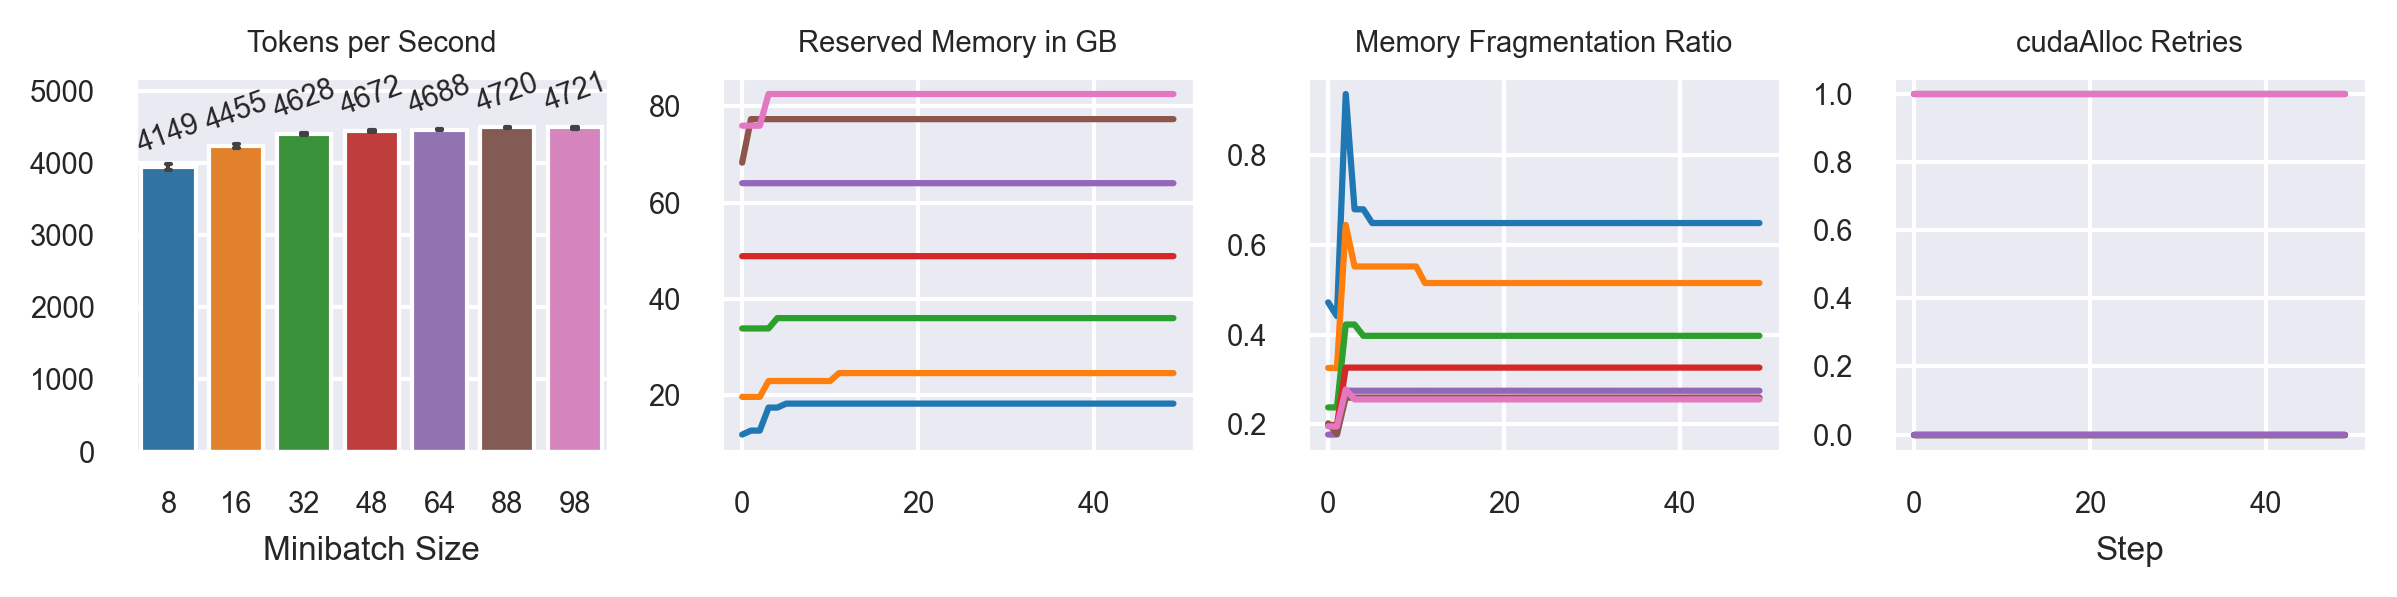

In [425]:
def show_barplot_values(ax, decimals=0):
    
    max_y = 0
    for (p_ix, p) in enumerate(ax.patches):
        #if p_ix >= (len(ax.patches) / 2):
        #p_ix = p_ix - (len(ax.patches) / 2)
        _x = p.get_x() + p.get_width() / 2
        _y = p.get_y() + (p.get_height() * 1.05)
        max_y = max(max_y, _y)
        if decimals == 2:
            value = '{:.2f}'.format(_y)
        elif decimals == 1:
            value = '{:.1f}'.format(_y)
        elif decimals == 0:
            value = '{:.0f}'.format(_y)
        ax.text(_x, _y, value, ha="center", rotation=20)
        
    visualized_max_y = max_y * 1.10
    ax.set_ylim([0, visualized_max_y])

def speed_mem_plot(df, x, figsize=(8,2), title=None):
    
    df["reserved_gb.all_current"] = df["03_gpu_mem/reserved_bytes.all.current"] / 1000**3
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=figsize)
    ax1 = sns.barplot(
        data=df,
        x=x,
        y="01_general/tokens_per_s",
        ax=ax1,
        errorbar=("ci", 95),
        errwidth=1,
        capsize=0.08)
    ax1.set_xticklabels(df[x].unique(), rotation=0)#, ha='right')
    ax1.set_xlabel("Minibatch Size")
    #ax1.set_xlabel("")
    ax1.set_ylabel("")
    ax1.set_title("Tokens per Second")
    show_barplot_values(ax = ax1)
    
    ax2 = sns.lineplot(
        data=df,
        x="step",
        y="reserved_gb.all_current",
        ax=ax2,
        hue=x)
    ax2.set_title("Reserved Memory in GB")
    ax2.set_ylabel("")
    ax2.set_xlabel("")
    ax2.legend_.remove()

    ax3 = sns.lineplot(
        data=df,
        x="step",
        y="04_agg_gpu/memory_fragmentation_ratio",
        ax=ax3,
        hue=x)
    ax3.set_title("Memory Fragmentation Ratio")
    ax3.set_ylabel("")
    ax3.set_xlabel("")
    ax3.legend_.remove()

    
    ax4 = sns.lineplot(
        data=df,
        x="step",
        y="03_gpu_mem/num_alloc_retries",
        ax=ax4,
        hue=x)
    ax4.set_title("cudaAlloc Retries")
    ax4.set_ylabel("")
    ax4.legend_.remove()
    ax4.set_xlabel("Step")
    
    #ax2.set_ylim(line_ylim)
    if title != None:
        fig.suptitle(title)
        
    fig.tight_layout()
    return ax1, ax2, ax3, ax4


set_fontsizes(7,8,8)

#valid_runs = [
#    "FSDP-9",
#    "FSDP-10"
#]

#valid_runs = [
#    "FSDP-15",
#    "FSDP-16",
#    "FSDP-17",
    #"FSDP-23",
#    "FSDP-19",
#    "FSDP-25",
#]

valid_runs = [
    "CAI_Gemini-8",
    "CAI_Gemini-16",
    "CAI_Gemini-32",
    "CAI_Gemini-48",
    "CAI_Gemini-64",
    "CAI_Gemini-88",
    "CAI_Gemini-98",
]

temp_df = runs_df.copy().query(f"group_name in {valid_runs} and global_rank=='0'")
temp_df = temp_df.sort_values(by=["03_gpu_mem/reserved_bytes.all.current"])

x = "minibatch_size"
ax1, ax2, ax3, ax4 = speed_mem_plot(df=temp_df, x=x)

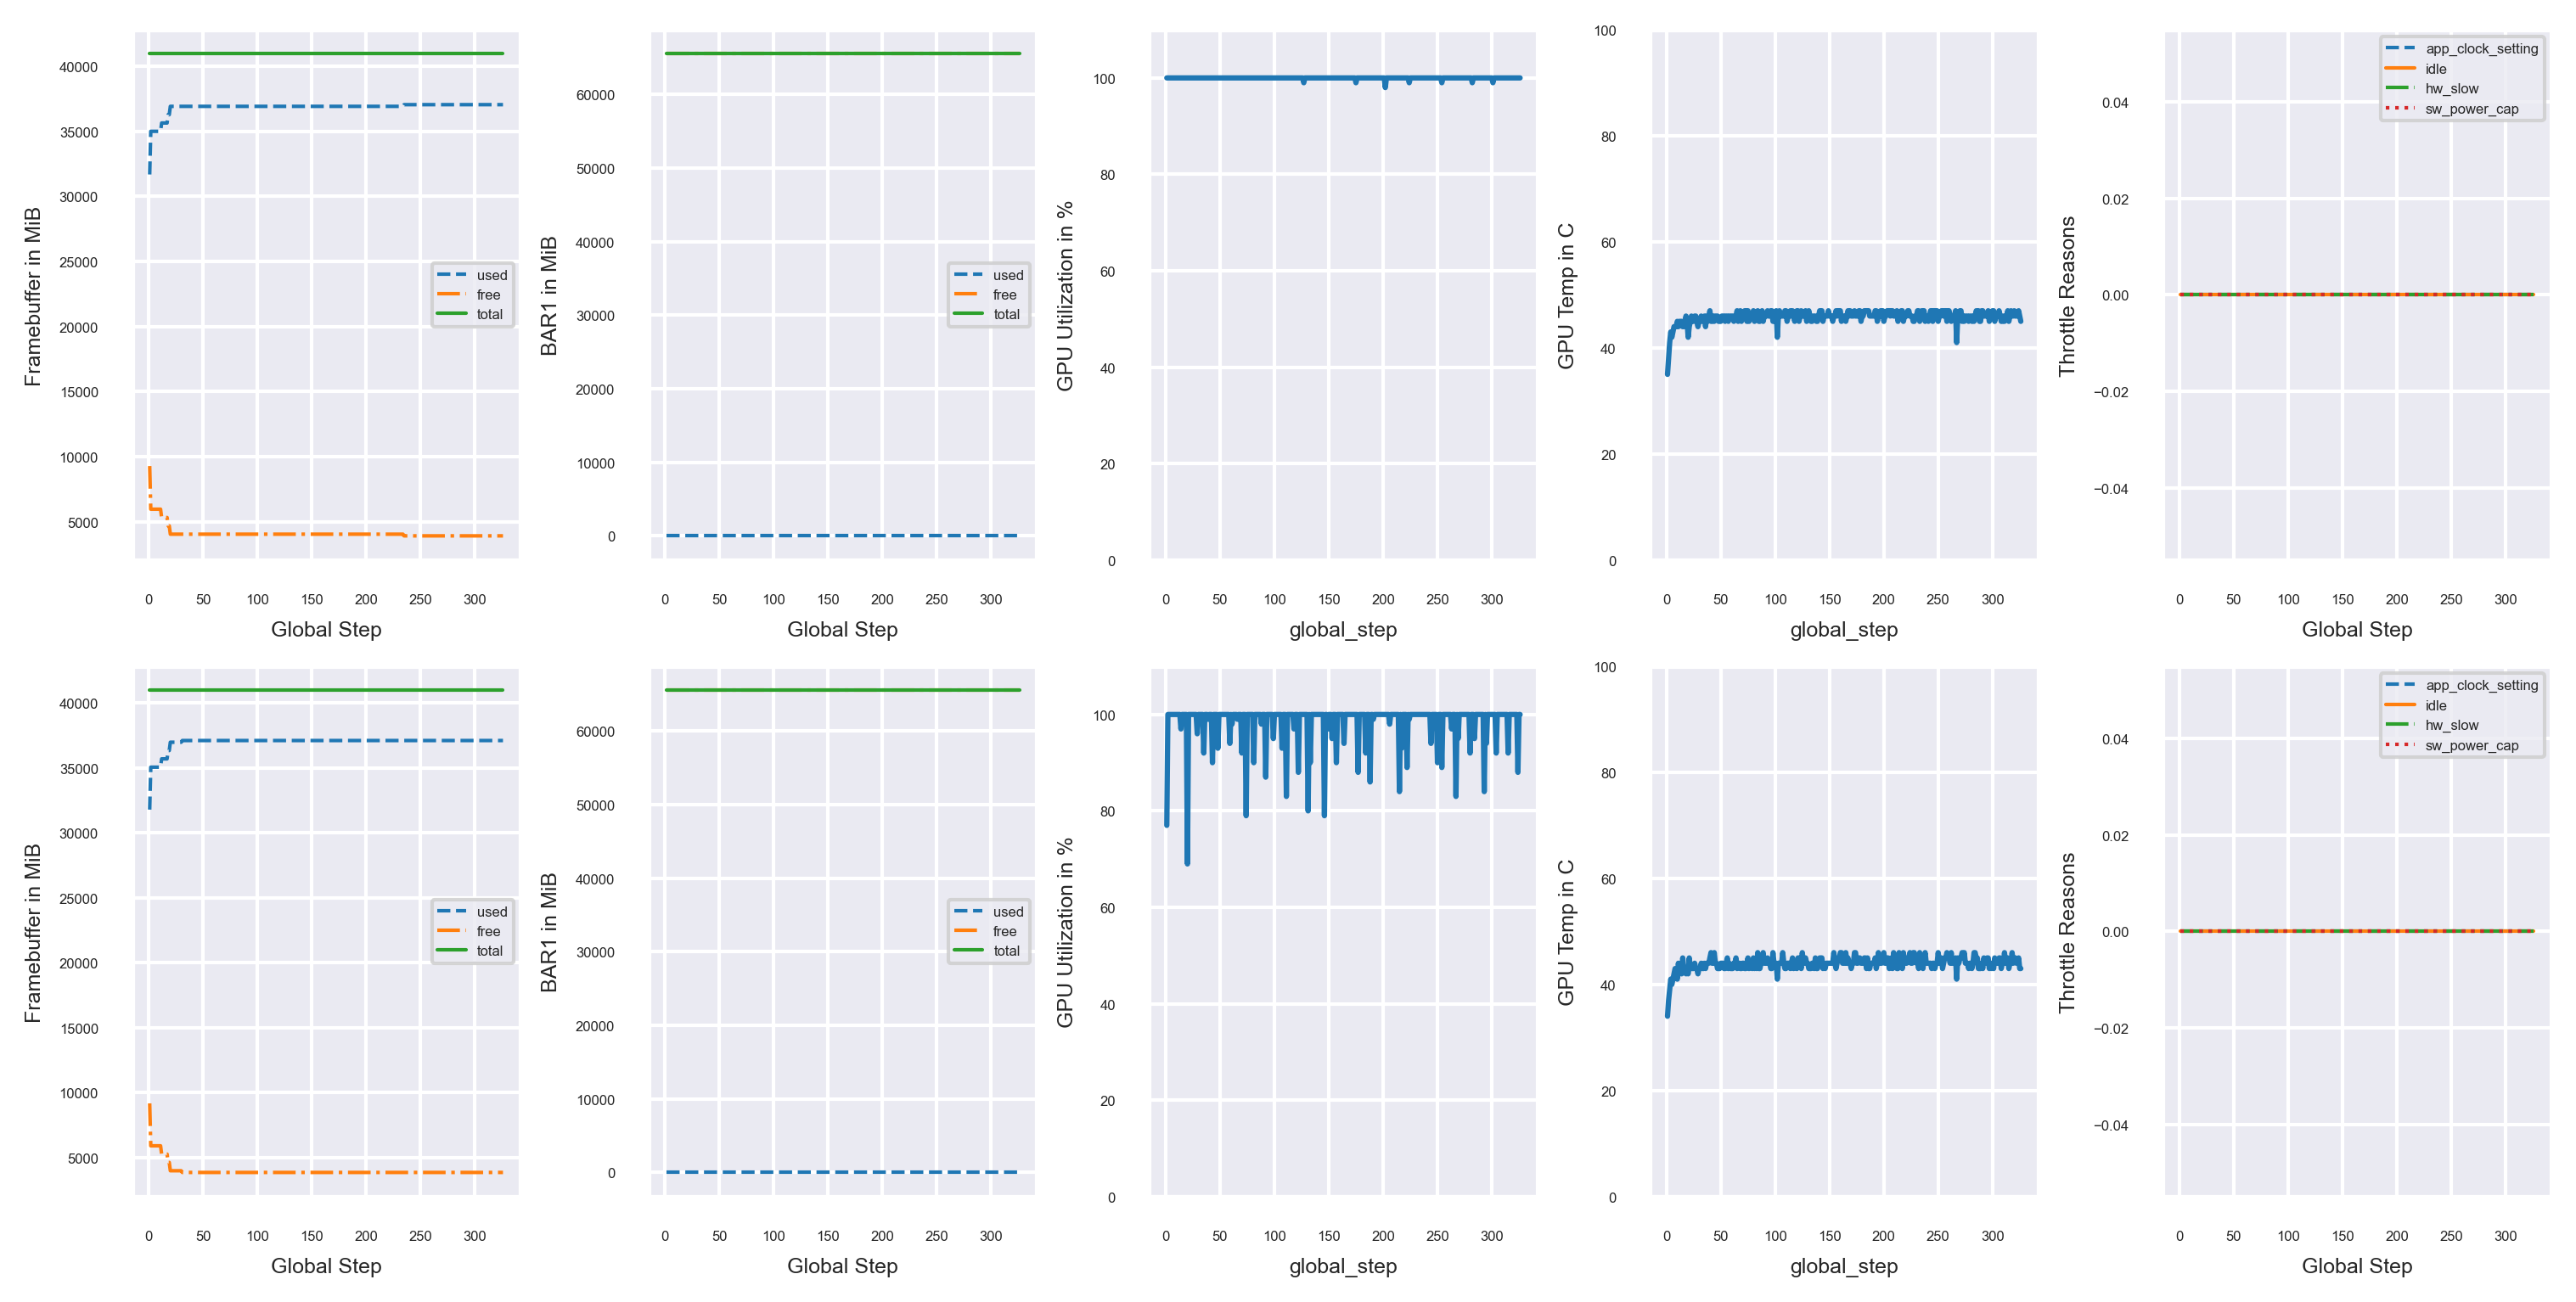

In [300]:
# ONLY GROUP NAME, as each rank logs the CUDA API for ALL gpus
temp_df = runs_df.query("run_name=='FSDP-63-r0'").copy()

def get_gpu_count(df):
    # filter by column count of temp_in_C as we log all metrics on a single process
    return len([ix for ix in df.columns if ix.endswith("temp_in_C")])

gpu_count = get_gpu_count(df = temp_df)
set_fontsizes(4,6,8)
fig, axs = plt.subplots(gpu_count, 5, figsize=(10, 5), layout='constrained')

gpu_smi_group_key = "05_gpu_smi/"

throttle_causes = [
    "",
    "",
    "",
    "clocks_throttle_reason_sw_power_cap"
]

def plot_throttle_reason(data, prefix, y_label, ax):
    
    x  = data["global_step"].reset_index(drop=True)
    y1 = data[f"{gpu_smi_group_key}{prefix}clocks_throttle_reason_applications_clocks_setting"].reset_index(drop=True)
    y2 = data[f"{gpu_smi_group_key}{prefix}clocks_throttle_reason_gpu_idle"].reset_index(drop=True)
    y3 = data[f"{gpu_smi_group_key}{prefix}clocks_throttle_reason_hw_slowdown"].reset_index(drop=True)
    y4 = data[f"{gpu_smi_group_key}{prefix}clocks_throttle_reason_sw_power_cap"].reset_index(drop=True)
    
    legend_handles = []
    
    y1_h, = ax.plot(x, y1, linestyle="dashed", label="app_clock_setting", linewidth=1)
    y2_h, = ax.plot(x, y2, linestyle='solid', label="idle", linewidth=1)
    y3_h, = ax.plot(x, y3, linestyle='dashdot', label="hw_slow", linewidth=1)
    y4_h, = ax.plot(x, y4, linestyle='dotted', label="sw_power_cap", linewidth=1)
    
    legend_handles.append(y1_h)
    legend_handles.append(y2_h)
    legend_handles.append(y3_h)
    legend_handles.append(y4_h)

    ax.set_xlabel("Global Step")
    ax.set_ylabel(y_label)
    ax.legend(handles=legend_handles)
    

def plot_smi_memory(data, prefix, used_key, total_key, free_key, y_label, ax):
    x  = data["global_step"].reset_index(drop=True)
    y1 = data[f"{gpu_smi_group_key}{prefix}{used_key}"].reset_index(drop=True)
    y2 = data[f"{gpu_smi_group_key}{prefix}{free_key}"].reset_index(drop=True)
    y3 = data[f"{gpu_smi_group_key}{prefix}{total_key}"].reset_index(drop=True)

    legend_handles = []
    
    y1_h, = ax.plot(x, y1, linestyle="dashed", label="used", linewidth=1)
    y2_h, = ax.plot(x, y2, linestyle='dashdot', label="free", linewidth=1)
    y3_h, = ax.plot(x, y3, linestyle='solid', label="total", linewidth=1)
    legend_handles.append(y1_h)
    legend_handles.append(y2_h)
    legend_handles.append(y3_h)

    ax.set_xlabel("Global Step")
    ax.set_ylabel(y_label)
    ax.legend(handles=legend_handles)

for gpu_nr in range(gpu_count):
    
    prefix = f"gpu_{gpu_nr}_"
    # we have a gpu x 5 grid
    index = gpu_nr * 5

    ax = axs.flat[index]
    plot_smi_memory(
        data=temp_df,
        prefix=prefix,
        used_key="fb_used_MiB",
        total_key="fb_total_MiB",
        free_key="fb_free_MiB",
        y_label="Framebuffer in MiB",
        ax=ax
    )

    index = index + 1
    ax = axs.flat[index]
    plot_smi_memory(
        data=temp_df,
        prefix=prefix,
        used_key="bar1_used_MiB",
        total_key="bar1_total_MiB",
        free_key="bar1_free_MiB",
        y_label="BAR1 in MiB",
        ax=ax
    )
    
    index = index + 1
    ax = axs.flat[index]
    ax = sns.lineplot(
        data=temp_df,
        x="global_step",
        y=f"{gpu_smi_group_key}{prefix}gpu_util_in_percent",
        ax=ax,
    )
    ax.set_ylim([0,110])
    ax.set_ylabel("GPU Utilization in %")
    
    index = index + 1
    ax = axs.flat[index]
    ax = sns.lineplot(
        data=temp_df,
        x="global_step",
        y=f"{gpu_smi_group_key}{prefix}temp_in_C",
        ax=ax,
    )
    ax.set_ylim([0,100])
    ax.set_ylabel("GPU Temp in C")
    
    index = index + 1
    ax = axs.flat[index]
    plot_throttle_reason(
        data=temp_df,
        prefix=prefix,
        y_label="Throttle Reasons",
        ax=ax
    )